# Anime Face - Feature Visualization - VGG16 Model - TSNE
The intent with this notebook is to visualize the feature that the VGG16 model see through many of the models layers, using a pretrained VGG16 Model. Followed by Extracting the most intresting features with TSNE in order to get some visual representation of the differences between the images.

Dataset: [another anime face dataset](https://www.kaggle.com/datasets/scribbless/another-anime-face-dataset)

In [9]:
%pip install -q pip pydot matplotlib graphviz scikit-learn tensorflow[and-cuda]==2.14.1

Note: you may need to restart the kernel to use updated packages.


## Import all Modules and Configure GPU

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import pathlib
import os.path
from sklearn.manifold import TSNE
from keras.models import Model

from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input

import tensorflow as tf

# Initialize tf.distribute.MirroredStrategy
selected_devices = None #tf.config.list_logical_devices('CPU')
strategy = tf.distribute.MirroredStrategy(devices=selected_devices)
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of devices: 1


In [11]:
print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.14.1


## Load DataSet

In [12]:
def load_from_directory(data_dir, image_size, batch_size):
    def configure_for_performance(ds, AUTOTUNE, shuffleSize):
        if shuffleSize > 0:
            ds = ds.shuffle(buffer_size=shuffleSize, reshuffle_each_iteration=False)
        ds = ds.prefetch(buffer_size=AUTOTUNE)

        return ds

    data_train_dir = pathlib.Path(data_dir)
    train_ds = tf.keras.utils.image_dataset_from_directory(
        data_train_dir,
        interpolation='bilinear',
        color_mode='rgb',
        label_mode=None,
        follow_links=True,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size)
    #
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)

    # Translate [0,255] -> [0, 1]
    normalized_train_ds = train_ds.map(lambda x: normalization_layer(x))

    return configure_for_performance(normalized_train_ds, AUTOTUNE, 0)


In [13]:

BATCH_SIZE_PER_REPLICA = 16
BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

IMAGE_SIZE = (224, 224) # Size required by the VGG model.
NUM_IMAGES = 600

data_directory_path = "anime-data/"
data_dir = pathlib.Path(data_directory_path)

train_images = load_from_directory(data_dir, IMAGE_SIZE, BATCH_SIZE).take(int(NUM_IMAGES / BATCH_SIZE))

print("Train: Number of batches {0} of {1} elements".format(
    len(train_images), BATCH_SIZE))

Found 92108 files belonging to 1 classes.
Train: Number of batches 37 of 16 elements


## Prepare Models for Feature Extraction

In [14]:
selected_layers = ['block1_pool', 'block2_pool', 'block3_pool', 'block4_pool', 'block5_pool', 'fc1', 'fc2', 'predictions']

#
VGG = VGG19(weights='imagenet')
outputs = [VGG.get_layer(l).output for l in selected_layers]
models = [Model(VGG.input, output) for output in outputs]

# Plot Result - Plot Dimensional Reduction
Extract all feature for each configured model perform TSNE to extract the two feature with most correlation and to visualize it as a 2D image. 

In [15]:
def imscatter(x, y, image, ax=None, zoom=1):
	"""Plot image instead of dots."""
	ax = plt.gca()
	
	x, y = np.atleast_1d(x, y)
	artists = []
	for i, (x0, y0) in enumerate(zip(x, y)):

		image_proc = tf.image.resize(image, (192, 192))[[i % len(image)]]

		im = OffsetImage(image_proc, zoom=zoom)

		ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
		artists.append(ax.add_artist(ab))
		
	ax.update_datalim(np.column_stack([x, y]))
	ax.autoscale()
	return artists

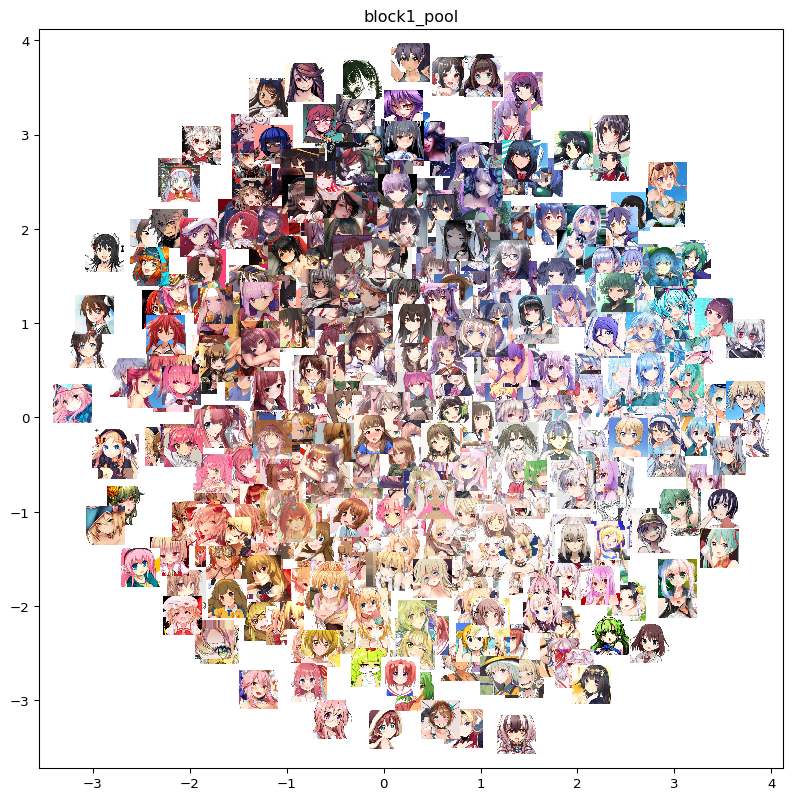

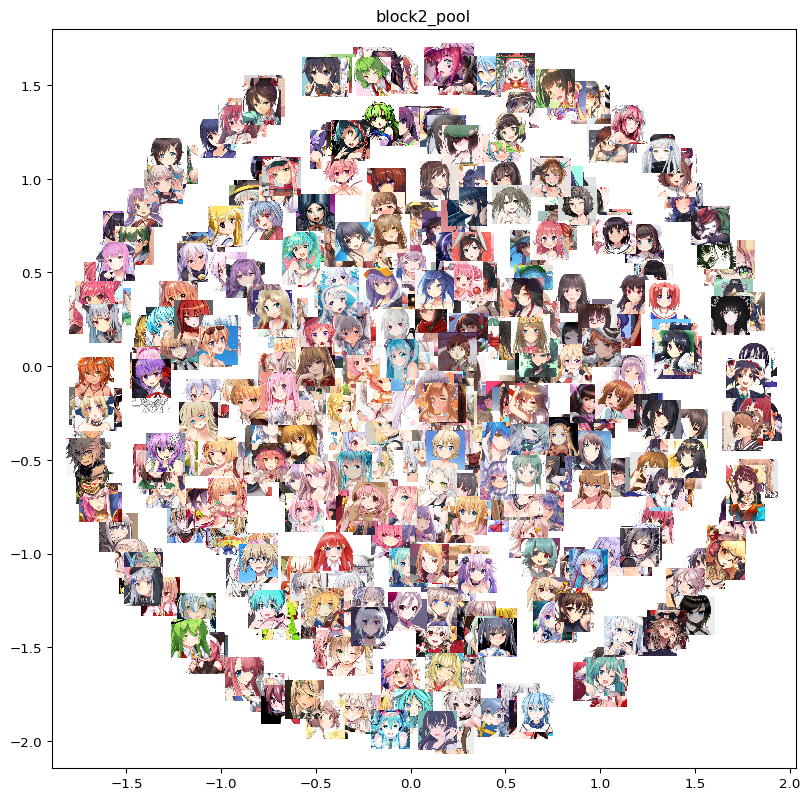

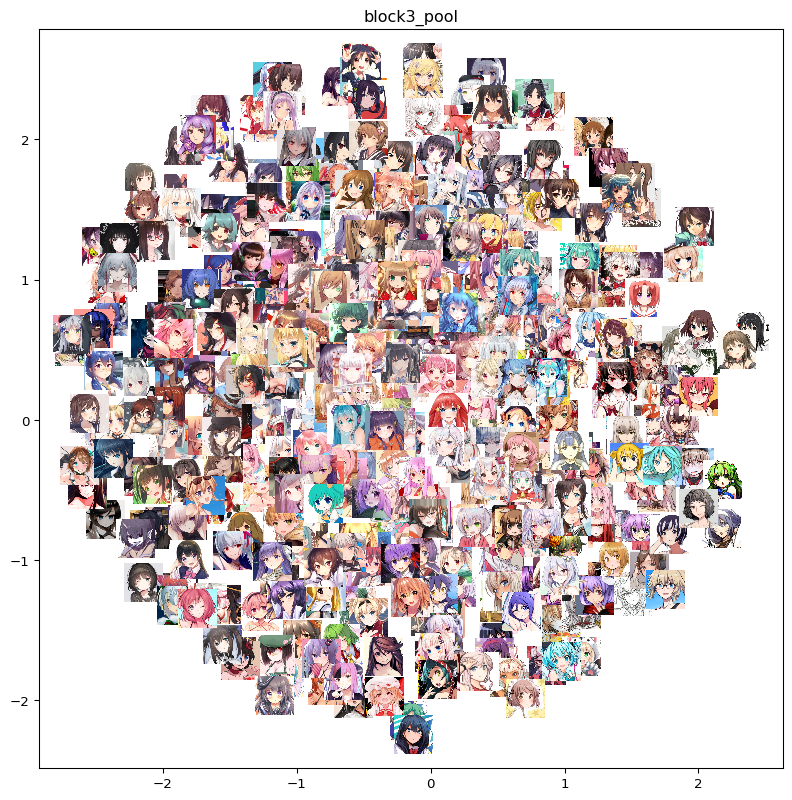

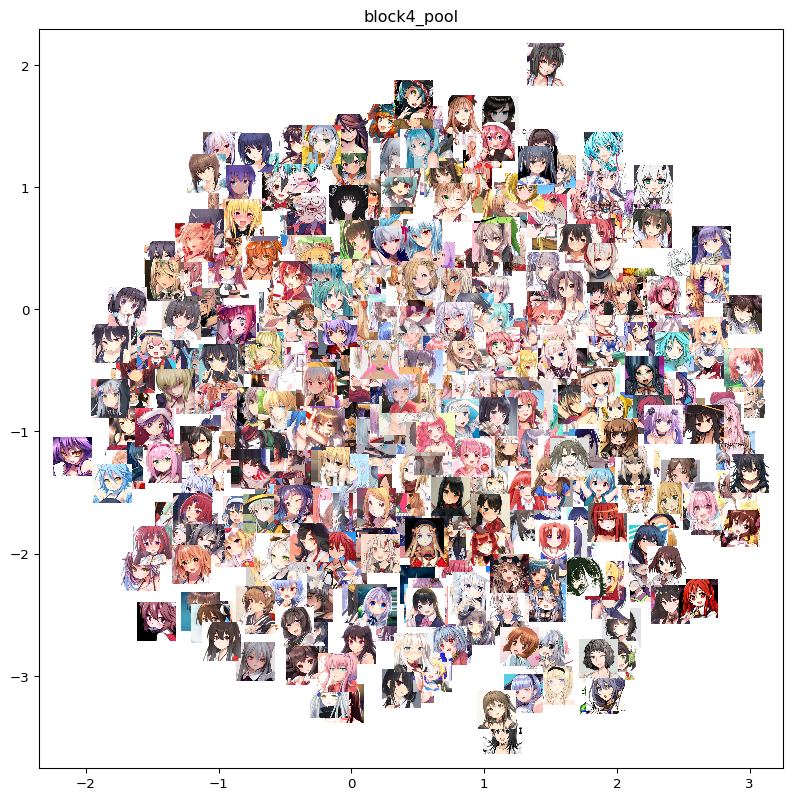

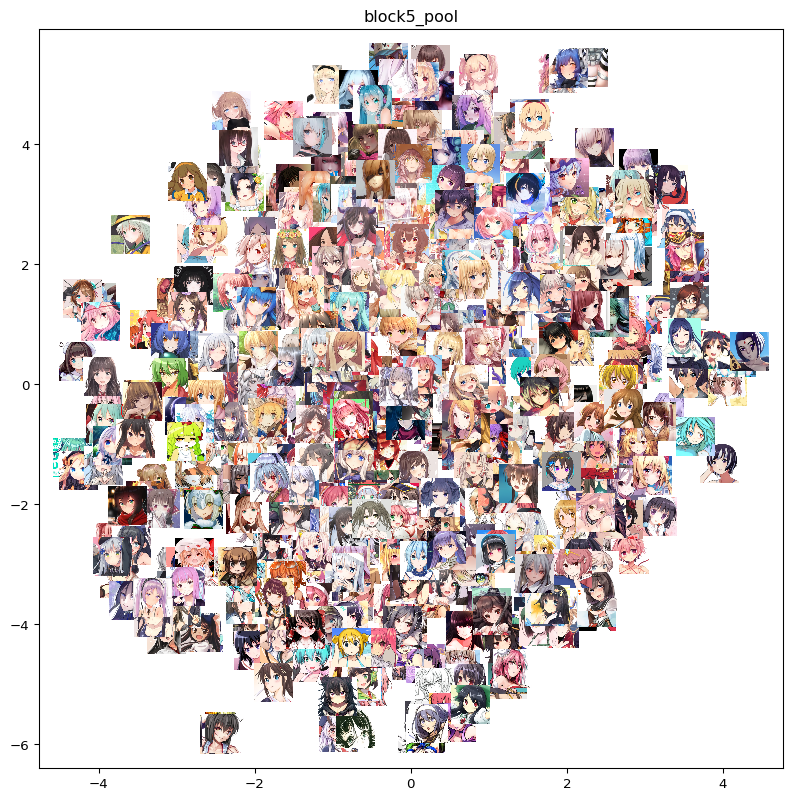

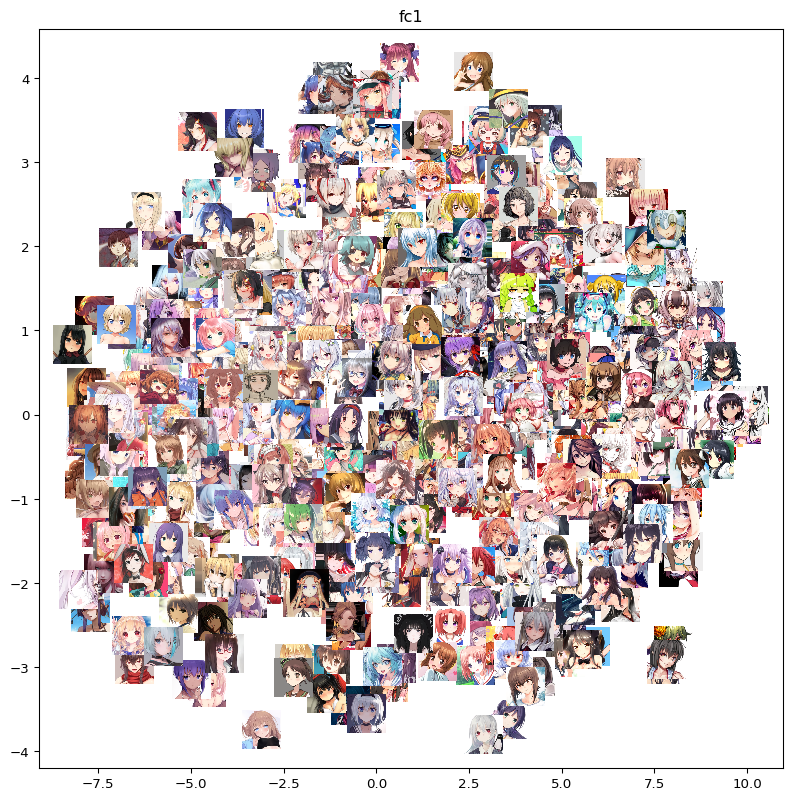

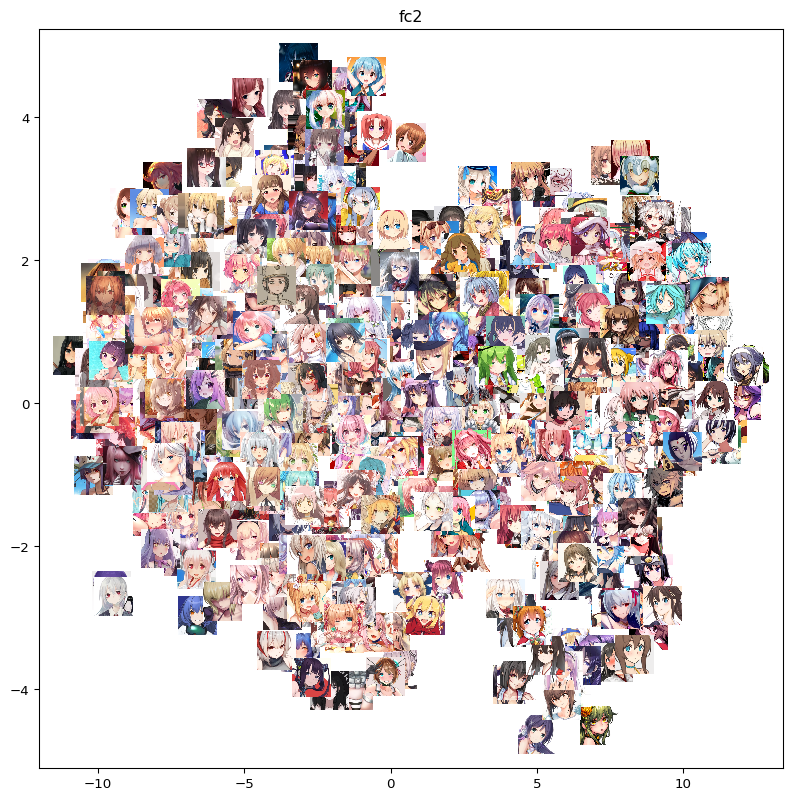

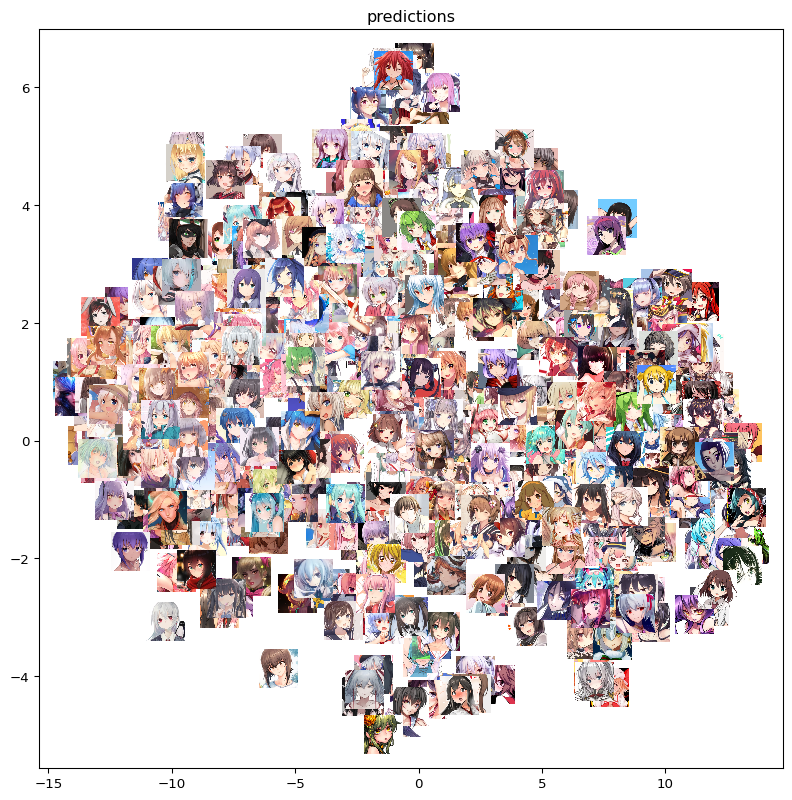

In [16]:
with strategy.scope():
    # Each model with different output.
    for i, m in enumerate(models):

        fig = plt.figure(figsize=(10, 2 * 5), dpi=96)

        batch_iter = iter(train_images)
        latent_init_value = []
        images = []

        # Extract each image latent space, iterative, since doing it with all data at once, cause it to allocate to much data...?
        for data_image_batch in batch_iter:
            latent = np.asarray(m.predict(preprocess_input(data_image_batch), verbose=0))
            for l in latent:
                latent_init_value.append(l)
            for im in data_image_batch:
                images.append(im)

        # Combine the latent space and reshape where the dim[0] == number of images, the rest the features.
        latent_value = np.asarray(latent_init_value)
        latent_value = latent_value.reshape(latent_value.shape[0], np.product(latent_value.shape[1:]))

        if len(latent_value[0]) > 1:

            tsne = TSNE(n_components=2, init='pca', n_iter=2000, perplexity=100,
                        random_state=0, learning_rate='auto')
            X_tsne = tsne.fit_transform(latent_value)
            imscatter(X_tsne[:, 0], X_tsne[:, 1], images, zoom=0.15, ax=fig)
            plt.title(str.format("{0}", selected_layers[i]))

            plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

        plt.show(block=False)
        fig.savefig(str.format("output{0}.png", i))